# AE3: ASD Diagnostics

By Skye Chao

## Data Preparation

In [1]:
# imports
import pandas as pd
import re


# scrape data
data1 = pd.read_csv('train.csv')
data2 = pd.read_csv('train2.csv')
data = pd.concat([data1, data2], ignore_index = True)

# clean data
data.rename(columns = {'jaundice': 'jaundice_at_birth', 'austim': 'family_mem_has_asd', 'score': 'AQ Sum'}, inplace = True)
data = data.drop(['used_app_before', 'age_desc', 'contry_of_res', 'result', 'ID'], axis = 1)

data.isnull().sum()
question_mark_counts = data.applymap(lambda x: x == "?").sum()
question_mark_counts
data.dtypes
data[['age', 'Class/ASD']] = data[['age', 'Class/ASD']].astype(int)
data[['gender','ethnicity','jaundice_at_birth','family_mem_has_asd', 'Class/ASD']] = data[['gender','ethnicity','jaundice_at_birth','family_mem_has_asd', 'Class/ASD']].astype(str).applymap(lambda x: x.lower())
data['ethnicity'] = data['ethnicity'].replace('?', data['ethnicity'].mode()[0])
data['relation'] = data['relation'].replace('?', data['relation'].mode()[0])

# encode values
data['gender'] = data['gender'].map({'m': 1, 'f': 0})
data[['jaundice_at_birth', 'family_mem_has_asd']] = data[['jaundice_at_birth', 'family_mem_has_asd']].applymap(lambda x: 1 if x == 'yes' else 0)

data = data.drop_duplicates()
data

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice_at_birth,family_mem_has_asd,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,white-european,0,0,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,1,white-european,0,0,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,1,white-european,0,1,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,0,white-european,0,0,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,1,white-european,0,0,Self,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0,0,1,1,1,1,1,1,1,0,24,1,pasifika,0,0,Self,0
1596,1,1,0,0,1,0,0,0,1,1,17,0,asian,0,0,Self,0
1597,0,0,0,0,0,0,1,0,1,1,18,1,white-european,1,0,Self,1
1598,1,1,1,1,1,1,0,1,1,1,19,0,middle eastern,0,1,Relative,0


## Classification Model

In [8]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# training data
X = data.drop(columns = ['Class/ASD','ethnicity', 'relation'], axis = 1)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# classification label
y_clas = data['Class/ASD']


# classification model
def classify(user_df):
    """
    input: dataframe of user's answers
    output: none
    funct: prints classification of having ASD (yes/no)

    """
    # fit model
    model = RandomForestClassifier(random_state = 0)
    model.fit(X, y_clas)
    
    # predict
    prediction = model.predict(user_df)
    probabilities = model.predict_proba(user_df)  
    confidence = max(probabilities[0]) * 100  # highest probability for the predicted class
    
    diagnosis = 'On the Spectrum' if prediction[0] == '1' else 'Not on the Spectrum'
    print('\nThis would predict you are:', diagnosis)
    print('Confidence in this classification:', f'{confidence:.2f}%')


    
def classify_perf():
    """
    input: none
    output: none
    funct: prints metrics for Classification Model (shows performance)
    
    """
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0)
    }

    model = RandomForestClassifier(random_state = 0)
    scores = cross_validate(model, X, y_clas, cv = 5, scoring = scoring)
    print('\nAverage Accuracy:', scores['test_accuracy'].mean(),
         '\nAverage Precision:', scores['test_precision'].mean(),
         '\nAverage Recall:', scores['test_recall'].mean(),
         '\nAverage F1:', scores['test_recall'].mean())


def feature_importance():
    """
    input: none
    output: none
    funct: prints feature importances for classification model
    
    """
    # classification model
    clas_model = RandomForestClassifier(random_state = 0)
    clas_model.fit(X, y_clas)    
    
    importances = clas_model.feature_importances_
    feature_importances = pd.DataFrame(importances, index = X.columns, columns = ['importance']).sort_values('importance', ascending = False)
    print("Feature importances for regression model:\n", feature_importances)
    

feature_importance() # prompted me to remove ethnicity and relation

classify_perf()

Feature importances for regression model:
                     importance
age                   0.260474
A6_Score              0.114965
A4_Score              0.091133
A3_Score              0.085594
A9_Score              0.076164
A5_Score              0.061997
A7_Score              0.047207
gender                0.042079
A8_Score              0.039666
A2_Score              0.038008
family_mem_has_asd    0.037937
A10_Score             0.036723
jaundice_at_birth     0.036617
A1_Score              0.031435

Average Accuracy: 0.8342226508089574 
Average Precision: 0.8320852452368023 
Average Recall: 0.8342226508089574 
Average F1: 0.8342226508089574


### User Diagnosis

In [9]:
# ASD AQ-10 Questions
questions = [
    "I often notice small sounds when others do not",
    "I usually concentrate more on the whole picture, rather than the small details",
    "I find it easy to do more than one thing at once",
    "If there is an interruption, I can switch back to what I was doing very quickly",
    "I find it easy to ‘read between the lines’ when someone is talking to me",
    "I know how to tell if someone listening to me is getting bored",
    "When I’m reading a story I find it difficult to work out the characters’ intentions",
    "I like to collect information about categories of things (e.g. types of car, bird, train, plant etc.)",
    "I find it easy to work out what someone is thinking or feeling just by looking at their face",
    "I find it difficult to work out people’s intentions"
]
answer_choices = ['Definitely Agree', 'Slightly Agree', 'Slightly Disagree', 'Definitely Disagree']

user = pd.DataFrame(columns = X.columns)
print('Let\'s Give You an Unofficial Diagnosis!')

# questions about themselves
print('First, please answer these questions about yourself: ')
user.loc[0, 'age'] = int(input('Age: ').strip())
user.loc[0, 'gender'] = 1 if input('Gender (M/F): ').strip().lower() == 'm' else 0
user.loc[0, 'jaundice_at_birth'] = 1 if input('Born with Jaundice (Y/N): ').strip().lower() == 'y' else 0
user.loc[0, 'family_mem_has_asd'] = 1 if input('Do you have a family member with ASD (Y/N): ').strip().lower() == 'y' else 0
user.fillna(0, inplace=True)

# AQ10 Questionaire
print('\nNext, please answer these 10 Questions from our Questionaire!')
print('Answer using the following answer choices.')
for i, answer_choice in enumerate(answer_choices):
    print(f"{i+1}: {answer_choice}")

for i, question in enumerate(questions):
    answer = input(question + ": ").strip()
    while not answer.isdigit() or int(answer) not in range(1,5):
        answer = input('Invalid Answer. Answer with a number between 1 - 4. Please Try Again: ')
    user.iloc[0,i] = answer   

user[['A1_Score', 'A7_Score', 'A8_Score', 'A10_Score']] = user[['A1_Score', 'A7_Score', 'A8_Score', 'A10_Score']].applymap(lambda x: 1 if x in ['1','2'] else 0)
user[['A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A9_Score']] = user[['A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A9_Score']].applymap(lambda x: 1 if x in ['3','4'] else 0)

classify(user)
          
          


Let's Give You an Unofficial Diagnosis!
First, please answer these questions about yourself: 
Age: 7
Gender (M/F): M
Born with Jaundice (Y/N): N
Do you have a family member with ASD (Y/N): Y

Next, please answer these 10 Questions from our Questionaire!
Answer using the following answer choices.
1: Definitely Agree
2: Slightly Agree
3: Slightly Disagree
4: Definitely Disagree
I often notice small sounds when others do not: 1
I usually concentrate more on the whole picture, rather than the small details: 3
I find it easy to do more than one thing at once: 
Invalid Answer. Answer with a number between 1 - 4. Please Try Again: 4
If there is an interruption, I can switch back to what I was doing very quickly: 4
I find it easy to ‘read between the lines’ when someone is talking to me: 4
I know how to tell if someone listening to me is getting bored: 3
When I’m reading a story I find it difficult to work out the characters’ intentions: 4
I like to collect information about categories of thin

## Clustering Model

/Users/my_mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


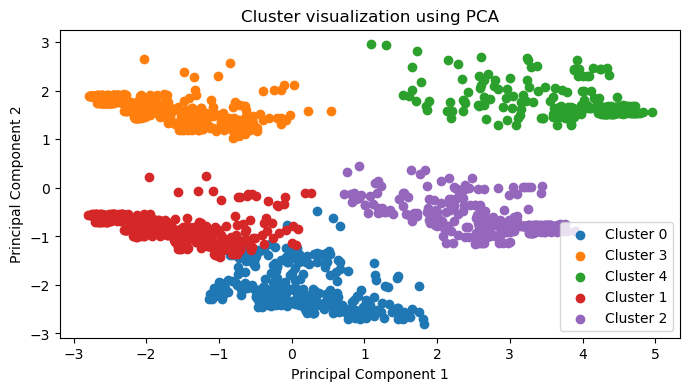

Statistics for Cluster 0:
         A1_Score    A2_Score    A3_Score    A4_Score    A5_Score    A6_Score  \
count  291.000000  291.000000  291.000000  291.000000  291.000000  291.000000   
mean     0.365151    0.214197    0.255917    0.295016    0.187235   -0.501169   
std      0.860775    1.013430    1.022605    1.001185    1.006932    0.453266   
min     -1.190959   -0.851055   -0.811601   -0.864867   -0.885887   -0.595010   
25%      0.839659   -0.851055   -0.811601   -0.864867   -0.885887   -0.595010   
50%      0.839659    1.175013    1.232133    1.156247    1.128812   -0.595010   
75%      0.839659    1.175013    1.232133    1.156247    1.128812   -0.595010   
max      0.839659    1.175013    1.232133    1.156247    1.128812    1.680643   

         A7_Score    A8_Score    A9_Score   A10_Score  ...  ethnicity_turkish  \
count  291.000000  291.000000  291.000000  291.000000  ...         291.000000   
mean     0.075915    0.176093    0.301927    0.588633  ...           0.006873   
s

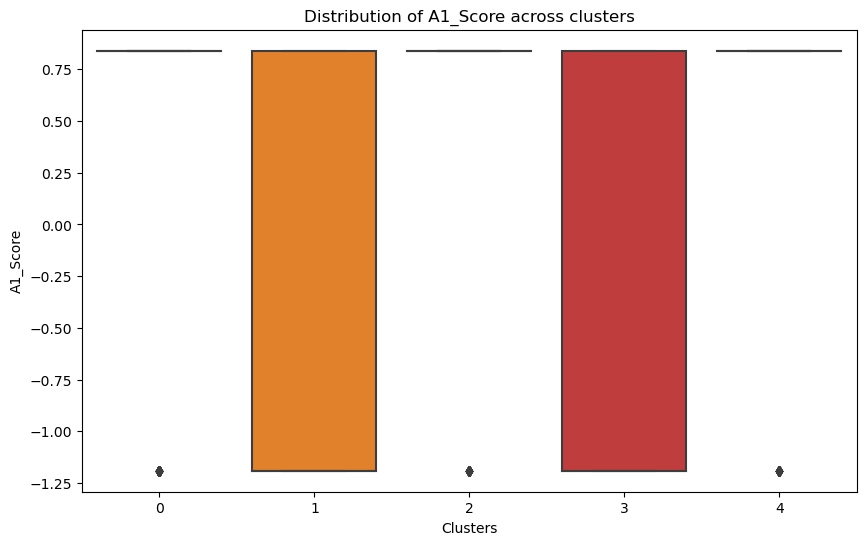

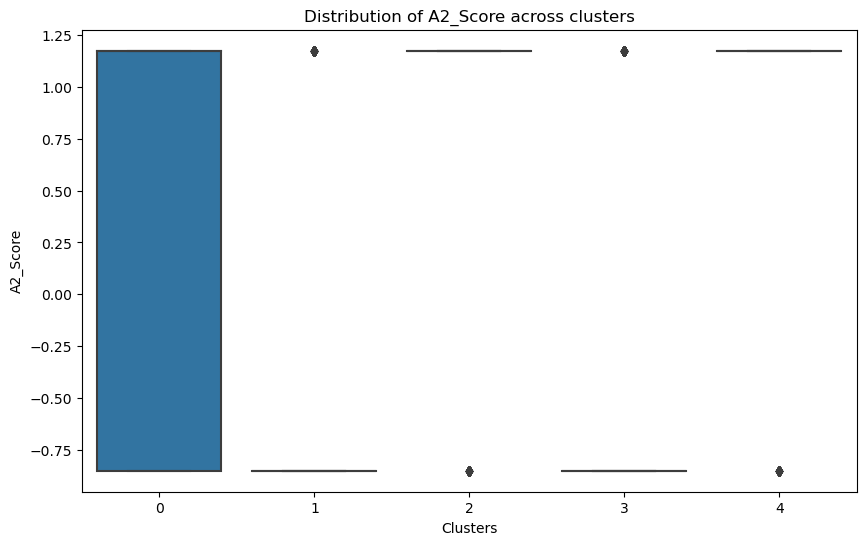

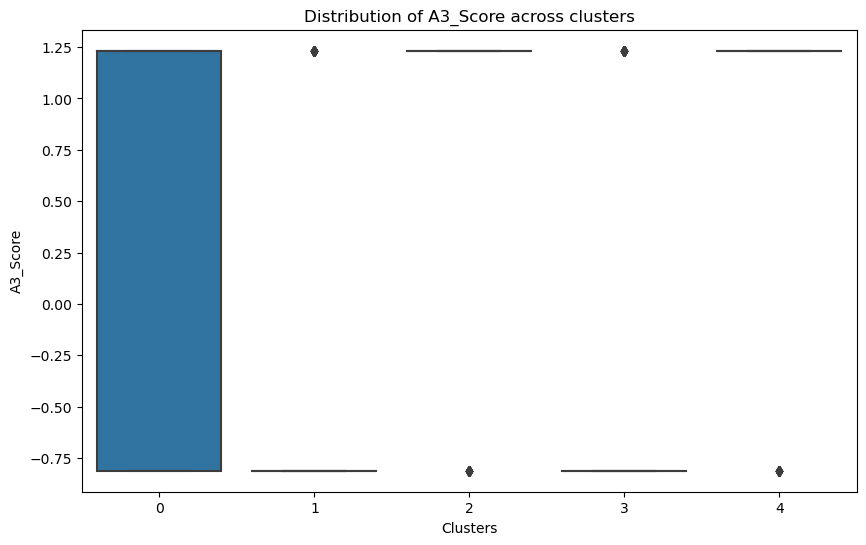

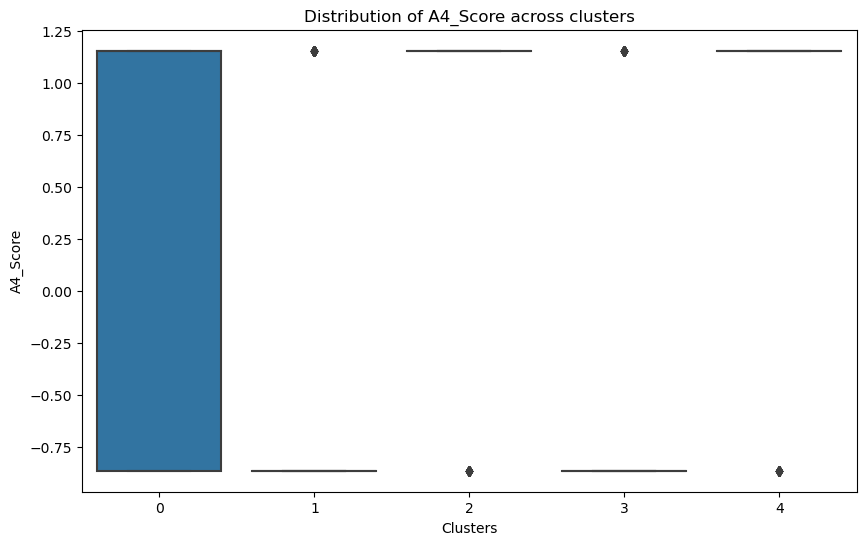

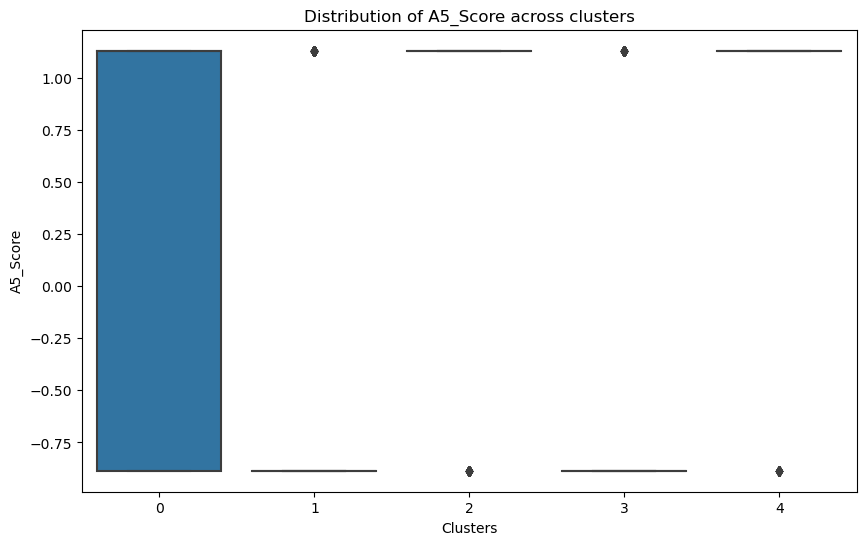

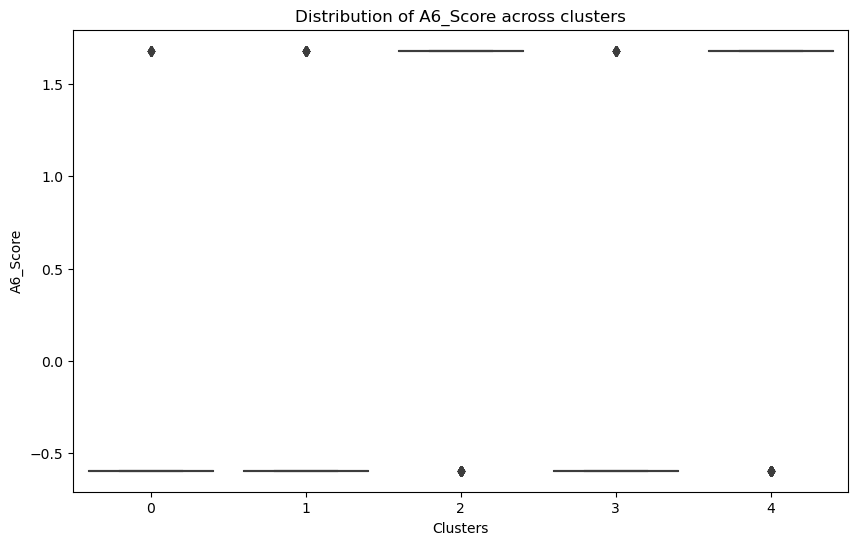

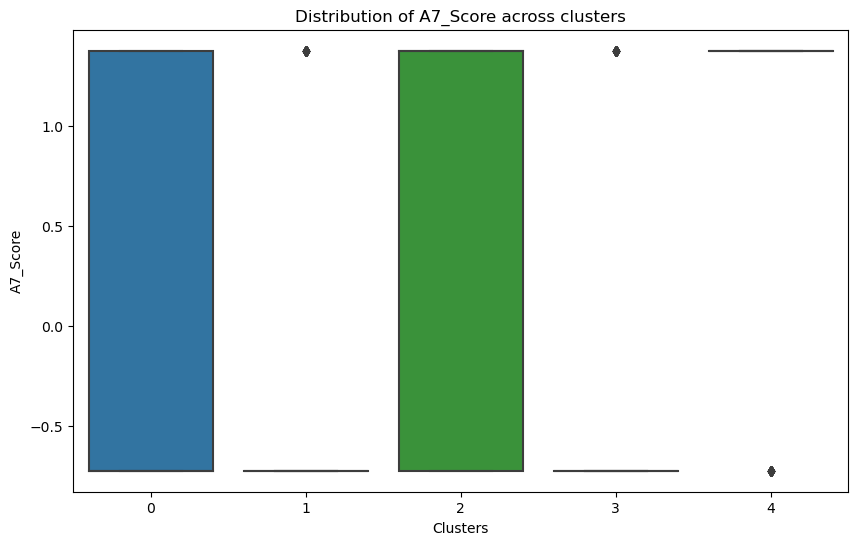

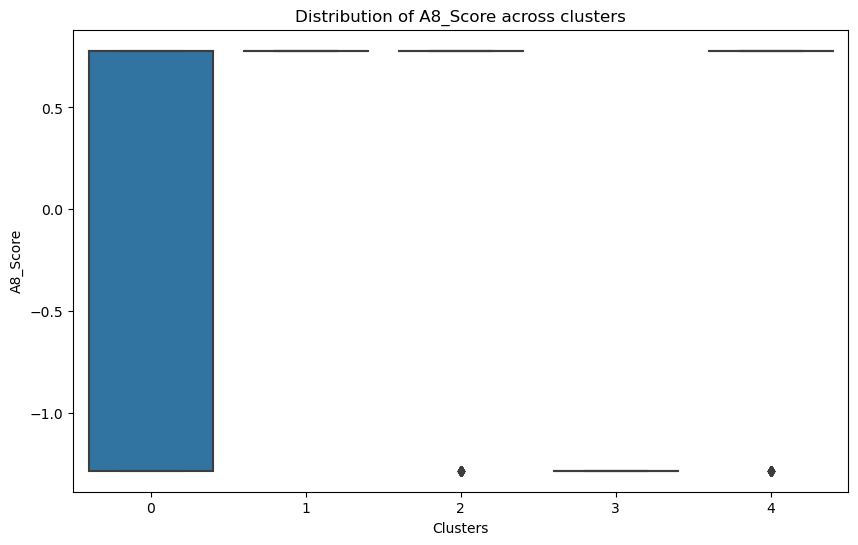

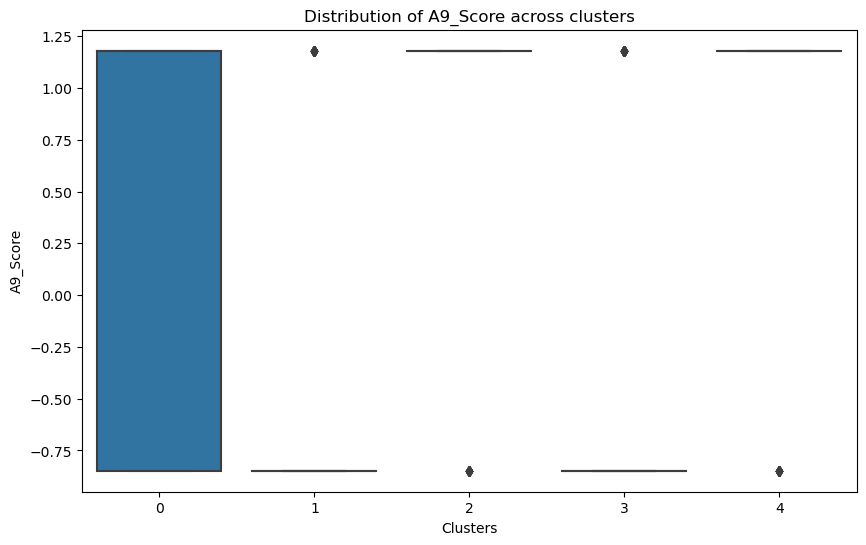

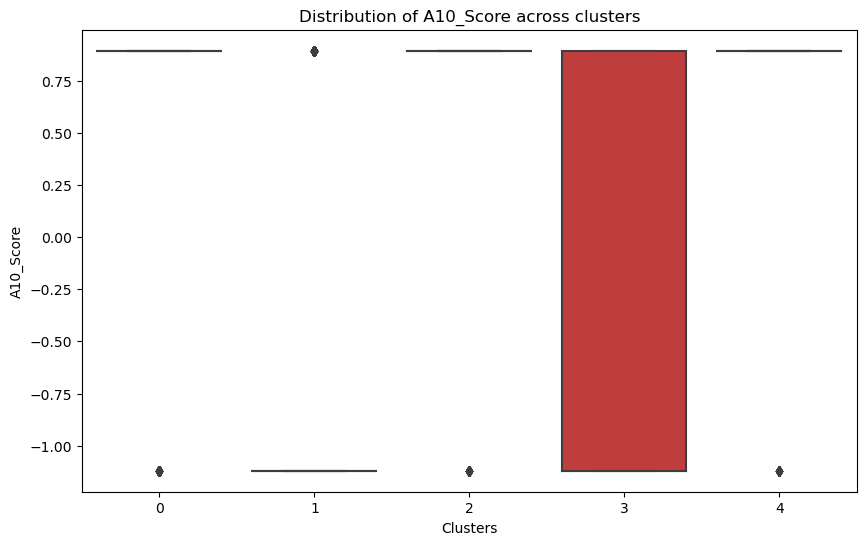

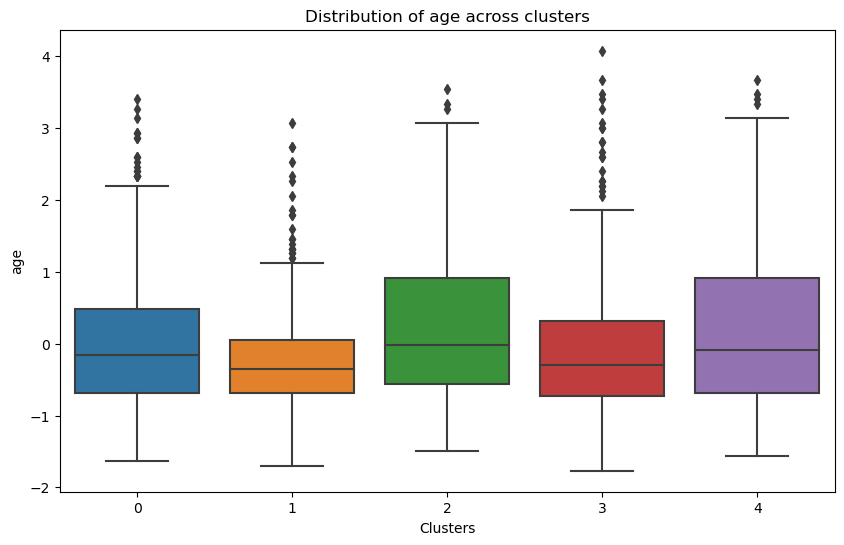

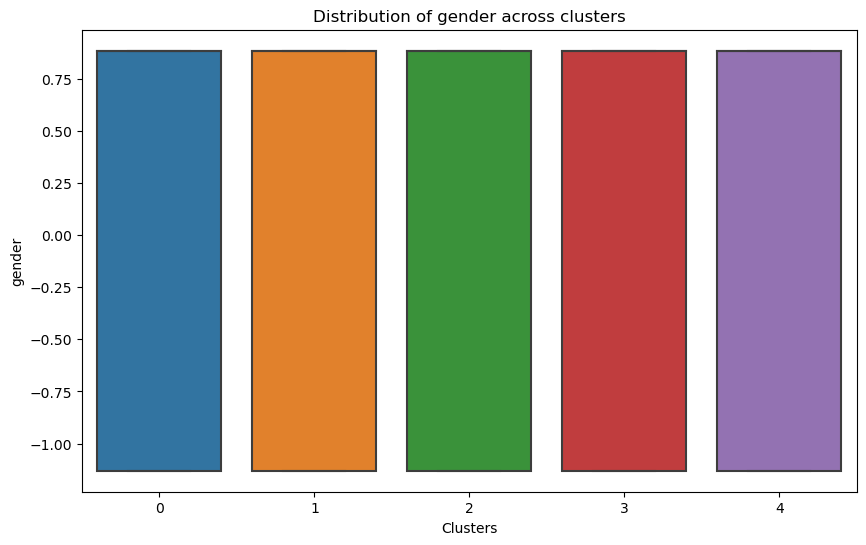

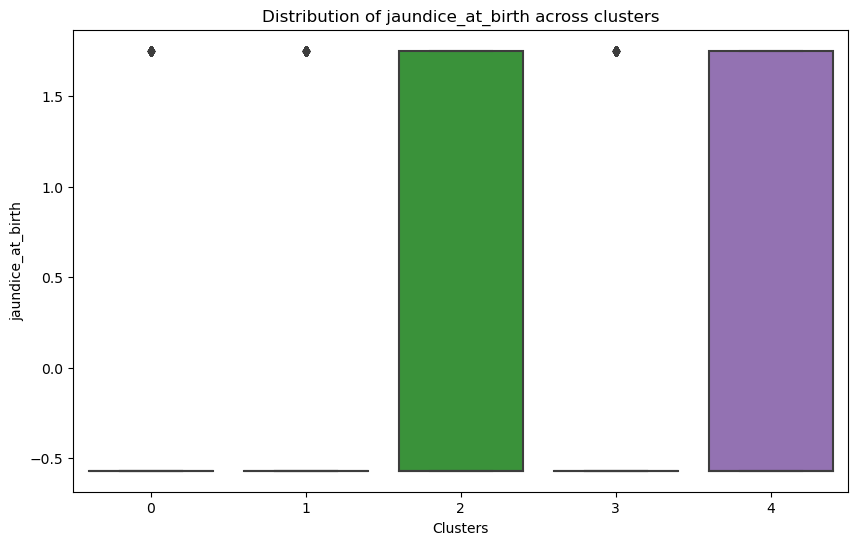

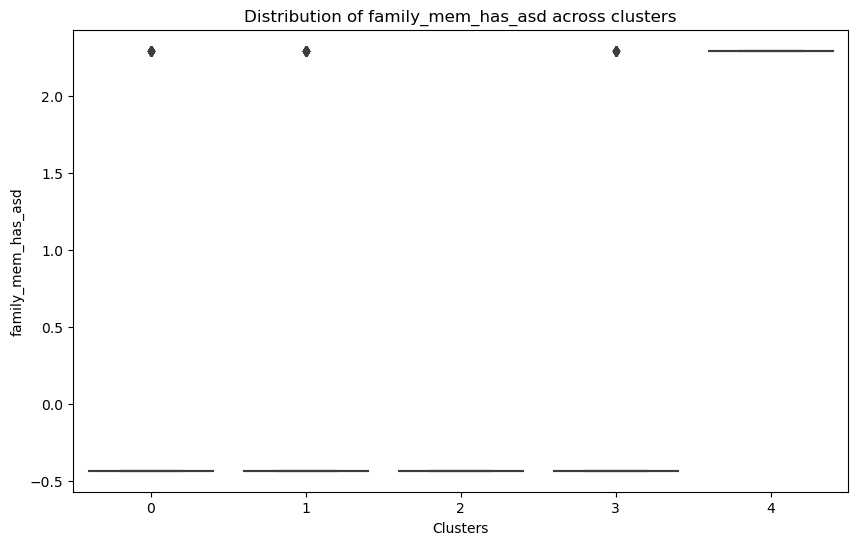

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


data.dtypes

# categorical data
categ_data = data[['ethnicity','relation']]
categ_data = pd.get_dummies(categ_data)

# numerical data
num_data = X

# combine
comb_data = pd.concat([num_data, categ_data], axis = 1)

# train model
model = KMeans(n_clusters = 5, random_state = 0)
model.fit(comb_data)

comb_data['Clusters'] = model.labels_

comb_data.head()

# dimension reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(comb_data)
comb_data['PCA1'] = pca_result[:, 0]
comb_data['PCA2'] = pca_result[:, 1]

# cluster visualization
plt.figure(figsize=(8, 4))
for cluster in comb_data['Clusters'].unique():
    cluster_data = comb_data[comb_data['Clusters'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
plt.title('Cluster visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# statistics
for i in range(model.n_clusters):
    cluster = comb_data[comb_data['Clusters'] == i]
    print(f"Statistics for Cluster {i}:")
    print(cluster.describe(), "\n")
    

# cluster data for each feature
for col in num_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Clusters', y=col, data=comb_data)
    plt.title(f'Distribution of {col} across clusters')
    plt.show()

In this section, I employed Unsupervised Learning by creating a KMeans model to cluster my data. My goal was to try to uncover hidden data, specifically natural grouping from shared characteristics. After standardizing my dataset and fitting it into a KMeans model, I identified 5 clusters, each representing unique features. To get a better understanding of each cluster, I created a boxplots for each feature and observed how they weighed into each cluster. This unsupervised learning section provided valuable insights into the diverse nature of Autism manifestations, demonstrating the potential of machine learning in enhancing the understanding and diagnostics of Autism Spectrum Disorder.